# Prise de Connaissance des Données

### Importation des packages

In [1]:
'''import packages
Versions:
imblearn (0.9.0) / joblib (1.1.0) / lightgbm (3.3.2) / matplotlib (3.5.0)
numpy (1.21.5) / pandas (1.3.5) / python (3.9.7)
scikit-learn (1.0.2) / seaborn (0.11.2) / shap (0.40.0)
'''

import time
import gc
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from tqdm import tqdm
from scipy.stats import uniform, randint

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     cross_validate, RandomizedSearchCV,
                                     learning_curve, train_test_split)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### Importation fichier .csv avec features engineering

Pour le prétraitement des données (notamment la partie feature engineering), la méthode sera directement importée d'un kernel kaggle (https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/script). Cela permettra d'obtenir un jeu de données presque entièrement prétraité (excepté le traitement des données manquantes).

In [2]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./Input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./Input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./Input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./Input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./Input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./Input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./Input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./Input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()

    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()

    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

    return df

#### Application du kernel Kaggle

In [3]:
start_time = time.time()
data = main()
print('temps d\'exécution = '
          f'{round((time.time() - start_time)/60, 2)} minutes')

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)
temps d'exécution = 1.93 minutes


In [4]:
pd.set_option('display.max_row',999)
pd.set_option('display.max_column',999)

In [5]:
data.set_index('SK_ID_CURR', inplace=True)
data.drop('index', axis=1, inplace=True)
# Changing infinite values to NaN
data.replace(to_replace=np.inf, value=np.nan, inplace=True)
data

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Busine

#### Séparation des données d'entrainement et des données de test

In [6]:
X_train = data[data['TARGET'].notna()].drop(columns='TARGET').copy()
y_train = data.loc[data['TARGET'].notna(), 'TARGET'].copy()
X_test = data[data['TARGET'].isna()].drop(columns='TARGET').copy()

In [7]:
X_train.dtypes.value_counts()

float64    621
uint8      133
int64       41
dtype: int64

### Traitement des valeurs manquantes

In [8]:
(data.isna().sum()/data.shape[0]).sort_values()

FONDKAPREMONT_MODE_reg oper spec account                                 0.000000
OCCUPATION_TYPE_Medicine staff                                           0.000000
OCCUPATION_TYPE_Private service staff                                    0.000000
OCCUPATION_TYPE_Realty agents                                            0.000000
OCCUPATION_TYPE_Sales staff                                              0.000000
OCCUPATION_TYPE_Secretaries                                              0.000000
OCCUPATION_TYPE_Security staff                                           0.000000
OCCUPATION_TYPE_Waiters/barmen staff                                     0.000000
WEEKDAY_APPR_PROCESS_START_FRIDAY                                        0.000000
WEEKDAY_APPR_PROCESS_START_MONDAY                                        0.000000
WEEKDAY_APPR_PROCESS_START_SATURDAY                                      0.000000
WEEKDAY_APPR_PROCESS_START_THURSDAY                                      0.000000
WEEKDAY_APPR_PRO

Il y a de nombreuses valeurs manquantes dans le tableau. Valeurs qui découlent, pour certaines d'entre-elles, directement du prétraitement (création de colonne pour les crédits refusés ou les crédits acceptés). Par conséquent, ces colonnes ne doivent pas être éliminées. Je vais donc mettre en place une fonction d'évaluation de différentes techniques d'imputation pour choisir la meilleure méthode. Pour plus de simplicité et de rapidité, je me limiterais à l'utilisation d'un "Simple Imputer".  
L'évaluation se fera grâce à un score orienté métier qui va être préalablement défini. Il correspondra à la proportion de personnes en capacité de rembourser qui se verraient refuser leur crédit dans le cas où 95% des défauts seraient détectés. Ce score permet de mieux rendre compte notre problématique métier mais aussi de mieux rendre compte de la qualité de la prédiction (comparé à l'accuracy) dans le cas de classes déséquilibrées 

In [9]:
# binary variables are isolated from the rest of variables
binary_var = []
quant_var = []
for col in tqdm(X_train.columns):
    if len(X_train[col].unique())<4:
        binary_var.append(col)
    else:
        quant_var.append(col)
    
    # As dataset is dense, dtype of values is compressed to a lower format
    if X_train[col].dtype=='int64':
        X_train = X_train.astype({col:'int16'}, copy=True)
    elif X_train[col].dtype=='float64':
        X_train = X_train.astype({col:'float32'}, copy=True)

100%|████████████████████████████████████████████████████████████████████████████████| 795/795 [03:44<00:00,  3.54it/s]


In [10]:
'''Definition of score. It calculates the false-positive ratio for a threshold
which gives a 95% recall.
'''
def false_positive_ratio(y, y_prob):
    # Calculation  of the two classes population in the validation set
    count_real_pos = sum(y == 1)
    count_real_neg = sum(y == 0)

    # Array giving the predict_proba results for each sample of the two classes
    # The predict_proba results are sorted for the positive class
    proba_real_pos = np.sort(y_prob[y==1])
    proba_real_neg = y_prob[y==0]

    # Definition of the fixed recall
    ratio_95 = count_real_pos * 0.95
    # Calculation of the threshold to reach the fixed recall
    thr = proba_real_pos[:int(-ratio_95)-1:-1][-1]

    # Returns the false-positive ratio considering the calculated threshold
    return sum(proba_real_neg >= thr) / count_real_neg

# Construction of score from the function
custom_score = make_scorer(false_positive_ratio,
                           greater_is_better=False,
                           needs_proba=True)

In [11]:
'''Function that will determine the best way to impute missing value by testing
different strategies. Evaluation is made with the Random Forest Classifier
using the default parameters as it is not influenced by distance.

Parameters:
- X: array-like of shape (n_samples, n_features)
The data to fit.
- y: array-like of shape (n_samples,)
The target variable to try to predict.
- binary_var: list
List of the binary features
- quant_var: list
List of quantitative features
- binary_strategy: list of str
List of SimpleImputer strategy for binary features. Could be 'mean', 'median',
'most_frequent' or 'constant'.
- quantitative_strategy: list of str
List of SimpleImputer strategy for quantitative features. Could be 'mean',
'median', 'most_frequent' or 'constant'.
- binary_fill_value: list of int
When strategy == 'constant' for binary features, fill_value is used to replace
all occurrences of missing_values by the values.
- quantitative_fill_value: list of int
When strategy == 'constant' for binary features, fill_value is used to replace
all occurrences of missing_values by the values.

Return:
- best_score: float
Lower false-positive ratio obtained for a fixed recall as mean of the
cross-validation scores.
- best_transformer: dict
combination of imputer which gives the best score. If strategy is different
from 'constant', the fill_value should not be considered.
'''

def Impute_srategy(X, y, binary_var, quant_var,
                   binary_strategy,
                   quantitative_strategy,
                   binary_fill_value=[0],
                   quantitative_fill_value=[0]):

    # Different strategy for binary and non-binary variables
    best_score = -2
    best_transformer = {}
    for bn_str in tqdm(binary_strategy):
        for qu_str in quantitative_strategy:
            for bn_val in binary_fill_value:
                for qu_val in tqdm(quantitative_fill_value):
                    trs = make_column_transformer((SimpleImputer(strategy=bn_str,
                                                                 fill_value=bn_val),
                                                   binary_var),
                                                  (SimpleImputer(strategy=qu_str,
                                                                 fill_value=qu_val),
                                                   quant_var)
                                                 )

                    # Imputation strategy followed by supervised learning
                    model = make_pipeline(trs,
                                          RandomForestClassifier(random_state=0))
                    # Cross-validation strategy
                    cv = StratifiedKFold(n_splits=3)
                    # Scores calculation 
                    scores = cross_val_score(model, X, y,
                                             scoring=custom_score, cv=cv)

                    # Parameters are saved only for best score
                    if np.mean(scores) > best_score:
                        best_score = np.mean(scores)
                        best_transformer['binary'] = bn_str
                        best_transformer['non-binary'] = qu_str
                        best_transformer['binary constant'] = bn_val
                        best_transformer['non-binary constant'] = qu_val

                    # No need to test all fill_value if strategy is not 'constant'
                    if qu_str != 'constant':
                        break
                if bn_str != 'constant':
                    break

    print('La plus petite proportion de prêt refusé à des personnes qui '
          f'auraient remboursé est de: {round(-best_score,2)}')
    print(f'Le meilleur transformer est: {best_transformer}')

    return best_score, best_transformer

In [12]:
score, trans = Impute_srategy(X=X_train, y=y_train,
                              binary_var=binary_var,
                              quant_var=quant_var,
                              binary_strategy=['most_frequent',
                                               'mean',
                                               'constant'],
                              quantitative_strategy=['mean',
                                                     'median',
                                                     'constant'],
                              binary_fill_value=[-1, 0],
                              quantitative_fill_value=[-999, -1, 0, 999]
                             )

  0%|                                                                                            | 0/4 [15:54<?, ?it/s]

  0%|                                                                                            | 0/4 [15:54<?, ?it/s]

  0%|                                                                                            | 0/4 [16:05<?, ?it/s]

  0%|                                                                                            | 0/4 [15:40<?, ?it/s]

  0%|                                                                                            | 0/4 [16:11<?, ?it/s]

  0%|                                                                                            | 0/4 [15:59<?, ?it/s]

  0%|                                                                                            | 0/4 [16:23<?, ?it/s]

  0%|                                                                                            | 0/4 [15:59<?, ?it/s]

100%|███████████████████████████

La plus petite proportion de prêt refusé à des personnes qui auraient remboursé est de: 0.84
Le meilleur transformer est: {'binary': 'constant', 'non-binary': 'median', 'binary constant': -1, 'non-binary constant': -999}


La meilleure technique d'imputation des valeurs manquantes est donc d'imputer par:
- La valeur -1 pour les variables binaires.
- La médiane pour les variables quantitatives.

Malheureusement, on voit qu'un recall de 95% implique un refus de crédit à 84% des personnes qui étaient en mesure de le rembourser. Afin de déterminer une valeur de recall plus adéquate, je vais faire une rapide étude de l'impact du recall et du nombre de faux positif sur les potentiels gain de la banque. Pour cela et dans une démarche de simplification extrême, il sera admis que tout défaut de paiement équivaut à une perte totale du capital et que chaque prêt rapporte 5% net en intérêt. Ainsi, il va être possible de déterminer le gain sur l'ensemble de l'échantillon considéré ainsi que le gain qu'il aurait été possible d'avoir si les personnes solvables n'avaient pas été éliminées.

In [12]:
'''Calculation of money gained or lost with credits in function of the
threshold used to determine if the loan is accepted or not.

Parameters:
- y: array-like of shape (n_samples,)
The real target values (0 or 1).
- y_proba: array-like of shape (n_samples,)
prediction of the model. Probability of being 1 for each observation.
- credit_amount: array-like of shape (n_samples,)
Amount of the credit for each observation
- interest: float
Interest of the credit arbitrarily chosen. The same for each credit
- lost_ratio: float
Fraction of credit lost in case of default. Has to be within (0, 1]

Return:
- results: DataFrame
Contains for each threshold (columns) the value of:
   - gain = interests from repaid credit minus lost credits
   - not_converted = interests not gained due to credit refusal
   - tpr (true positive ratio) = fraction of unpaid credit which has been
   rightly refused
   - fpr (false positive ratio) = fraction of repaid credit which has been
   wrongly refused
'''

def money_gain(y, y_proba, credit_amount, interest=0.05, lost_ratio=1.0):
    # Results stocked in a DataFrame
    results = pd.DataFrame(index=['threshold',
                                  'gain', 'not_converted',
                                  'tpr', 'fpr'])

    # Calculation of gain/loss regarding the threshold used
    for thr in np.arange(0, 1.005, 0.005):
        # Indexes of validation set predicted as 0 or 1
        idx_go = y[y_proba <= thr].index
        idx_nogo = y[y_proba > thr].index

        # Indexes of real 1 predicted as 0 (False Negative)
        # (credit accepted but with default)
        idx_FN = y[idx_go][y[idx_go] == 1].index
        # Indexes of real 0 predicted as 0 (True Negative)
        # (credit accepted with no default)
        idx_TN = y[idx_go][y[idx_go] == 0].index
        # Indexes of real 0 predicted as 1 (False Positive)
        # (credit not accepted with no default)
        idx_FP = y[idx_nogo][y[idx_nogo] == 0].index

        # lost_loans as the sum of the amount of all credits with default
        # multiply by the ratio lost
        lost_loans = lost_ratio * (credit_amount[idx_FN].sum())
        # lost_interest as net interest of all refused credits
        # which would be repaid
        lost_interest = credit_amount[idx_FP].sum() * interest
        # gain_interest as net interest of all accepted and repaid credits
        gain_interest = credit_amount[idx_TN].sum() * interest

        # gain = interests of repaid credits minus credits with default
        gain = gain_interest - lost_loans
        not_converted = lost_interest

        # Calculation of the true positive ratio (tpr = recall)
        # and false positive ratio (fpr)
        count_real_pos = sum(y == 1)
        count_real_neg = sum(y == 0)
        count_true_pos = sum(y[y_proba > thr]==1)
        count_false_pos = sum(y[y_proba > thr]==0)
        tpr = count_true_pos / count_real_pos
        fpr = count_false_pos / count_real_neg

        results[thr] = [thr, gain, not_converted, tpr, fpr]

    return results

In [13]:
'''Visualisation of the money gained or lost with credits in function of the
threshold used to determine if the loan is accepted or not.

Parameters:
- X: array-like of shape (n_samples, n_features)
The data to fit.
- y: array-like of shape (n_samples,)
The real target values (0 or 1).
- credit_amount_name: str
Name of the column in X representing the amount of the credit
- save_name: str
Common name for all the plots which are saved
- interest: float
Interest of the credit arbitrarily chosen. The same for each credit
- lost_ratio: float
Fraction of credit lost in case of default. Has to be within (0, 1]
- n_splits: int
Number of folds. Must be at least 2.

Return:
- results: dictionary of DataFrame
A dict with keys as folds from cross validation and Dataframe as value.
Each dataframe contains for each threshold (columns) the value of:
   - gain = interests from repaid credit minus lost credits
   - not_converted = interests not gained due to credit refusal
   - tpr (true positive ratio) = fraction of unpaid credit which has been
   rightly refused
   - fpr (false positive ratio) = fraction of repaid credit which has been
   wrongly refused
- gain_values: DataFrame
Contains for each remarkable value (index) the results values.
'''

def money_viz(X, y, model, save_name,
              interest=0.05, lost_ratio=1.0, n_splits=3):

    # Results stocked in a dict
    results = {}

    # Split of train set and validation set using StratifiedKFold function
    skf = StratifiedKFold(n_splits=n_splits)
    for nb, (train_idx, test_idx) in tqdm(enumerate(skf.split(X, y))):
        Xtr = X.iloc[train_idx,:]
        Xval = X.iloc[test_idx,:]
        ytr = y.iloc[train_idx]
        yval = y.iloc[test_idx]

        # Training of the model on train set and prediction on validation set
        model.fit(Xtr, ytr)
        proba = model.predict_proba(Xval)
        # yprob as the probabily to be positive (=credit default)
        yprob = proba[:,1]

        # Calculation of gain and loss
        results[f'fold{nb}'] = money_gain(y=yval, y_proba=yprob,
                                          credit_amount=X_train.iloc[test_idx, :]['AMT_CREDIT'],
                                          interest=interest,
                                          lost_ratio=lost_ratio)

    # Visualization of results
    sns.set_theme(style='whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, sharey=True, figsize=(15,17))
    ax3 = ax1.twinx()
    ax4 = ax2.twinx()

    max_val_g = np.zeros(5)
    max_val_gnc = np.zeros(5)
    zero_g = np.zeros(5)

    for i, (fold, res) in enumerate(results.items()):
        gain = np.array(res.loc['gain'])
        not_converted = np.array(res.loc['not_converted'])
        # Values for maximum gain
        max_val_g += res.iloc[:,gain.argmax()]
        # Values for maximum gain minus interest not converted
        max_val_gnc += res.iloc[:,(gain - not_converted).argmax()]
        # Values for zero gain
        zero_g += res.iloc[:,(np.argwhere(gain<0)[0][0])-1]

        if i == 0:
            ax1.plot(res.loc['tpr'], gain,
                     label='gain', c='b')
            ax1.plot(res.loc['tpr'], not_converted,
                     label='intérêts non convertis', c='r')
            ax1.plot(res.loc['tpr'], gain - not_converted,
                     label='gain - non convertis', c='g')
            ax3.plot(res.loc['tpr'], res.loc['fpr'],
                     label='part de faux positifs', c='black')
            ax2.plot(np.arange(0, 1.005, 0.005), gain,
                     label='gain', c='b')
            ax2.plot(np.arange(0, 1.005, 0.005), not_converted,
                     label='intérêts non convertis', c='r')
            ax2.plot(np.arange(0, 1.005, 0.005), gain - not_converted,
                     label='gain - non convertis', c='g')
            ax4.plot(np.arange(0, 1.005, 0.005), res.loc['fpr'],
                     label='part de faux positifs', c='black')
            ax4.plot(np.arange(0, 1.005, 0.005), res.loc['tpr'],
                     label='part de vrais positifs', c='violet')

        else:
            ax1.plot(res.loc['tpr'], gain, c='b')
            ax1.plot(res.loc['tpr'], not_converted, c='r')
            ax1.plot(res.loc['tpr'], gain - not_converted, c='g')
            ax3.plot(res.loc['tpr'], res.loc['fpr'], c='black')
            ax2.plot(np.arange(0, 1.005, 0.005), gain, c='b')
            ax2.plot(np.arange(0, 1.005, 0.005), not_converted, c='r')
            ax2.plot(np.arange(0, 1.005, 0.005), gain - not_converted, c='g')
            ax4.plot(np.arange(0, 1.005, 0.005), res.loc['fpr'], c='black')
            ax4.plot(np.arange(0, 1.005, 0.005), res.loc['tpr'], c='violet')

    ax1.set_title(('Gains et pertes potentiels en fonction du nombre de '
                   'défauts prédits'), fontsize=18, fontweight=650)
    ax1.set_xlabel('Part de défauts réels prédits', fontsize=16)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.set_ylabel('Gain / Pertes', fontsize=16)
    ax1.legend(bbox_to_anchor=(1.05, 1.02), loc='upper left', fontsize=14)

    ax2.set_title('Gains et pertes potentiels en fonction du seuil choisi',
                  fontsize=18, fontweight=650)
    ax2.set_xlabel('Seuil choisi', fontsize=16)
    ax2.tick_params(axis='x', labelsize=14)
    ax2.set_ylabel('Gain / Pertes', fontsize=16)
    ax2.legend(bbox_to_anchor=(1.05, 1.02), loc='upper left', fontsize=14)

    ax3.set_ylabel('Ratio', fontsize=16)
    ax3.grid(False)
    ax3.legend(bbox_to_anchor=(1.05, 0.85), loc='upper left', fontsize=14)

    ax4.set_ylabel('Ratio', fontsize=16)
    ax4.grid(False)
    ax4.legend(bbox_to_anchor=(1.05, 0.85), loc='upper left', fontsize=14)

    plt.savefig(f'./Output/gain_{save_name}.png',
                dpi=400,
                bbox_inches="tight"
               )
    plt.show()

    gain_values = pd.DataFrame(index=['max_gain',
                                      'max_gain-not_converted',
                                      'zero_gain'],
                              columns=['threshold',
                                       'gain', 'not_converted',
                                       'tpr', 'fpr'])

    max_val_g /= n_splits # Mean of all folds
    max_val_gnc /= n_splits # Mean of all folds
    zero_g /= n_splits # Mean of all folds
    gain_values.loc['max_gain'] = max_val_g
    gain_values.loc['max_gain-not_converted'] = max_val_gnc
    gain_values.loc['zero_gain'] = zero_g

    return results, gain_values

0it [00:00, ?it/s]C:\Users\Pierre\AppData\Local\Temp/ipykernel_9708/1780203564.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[thr] = [thr, gain, not_converted, tpr, fpr]
1it [05:20, 320.16s/it]C:\Users\Pierre\AppData\Local\Temp/ipykernel_9708/1780203564.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[thr] = [thr, gain, not_converted, tpr, fpr]
2it [10:41, 320.97s/it]C:\Users\Pierre\AppData\Local\Temp/ipykernel_9708/1780203564.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually

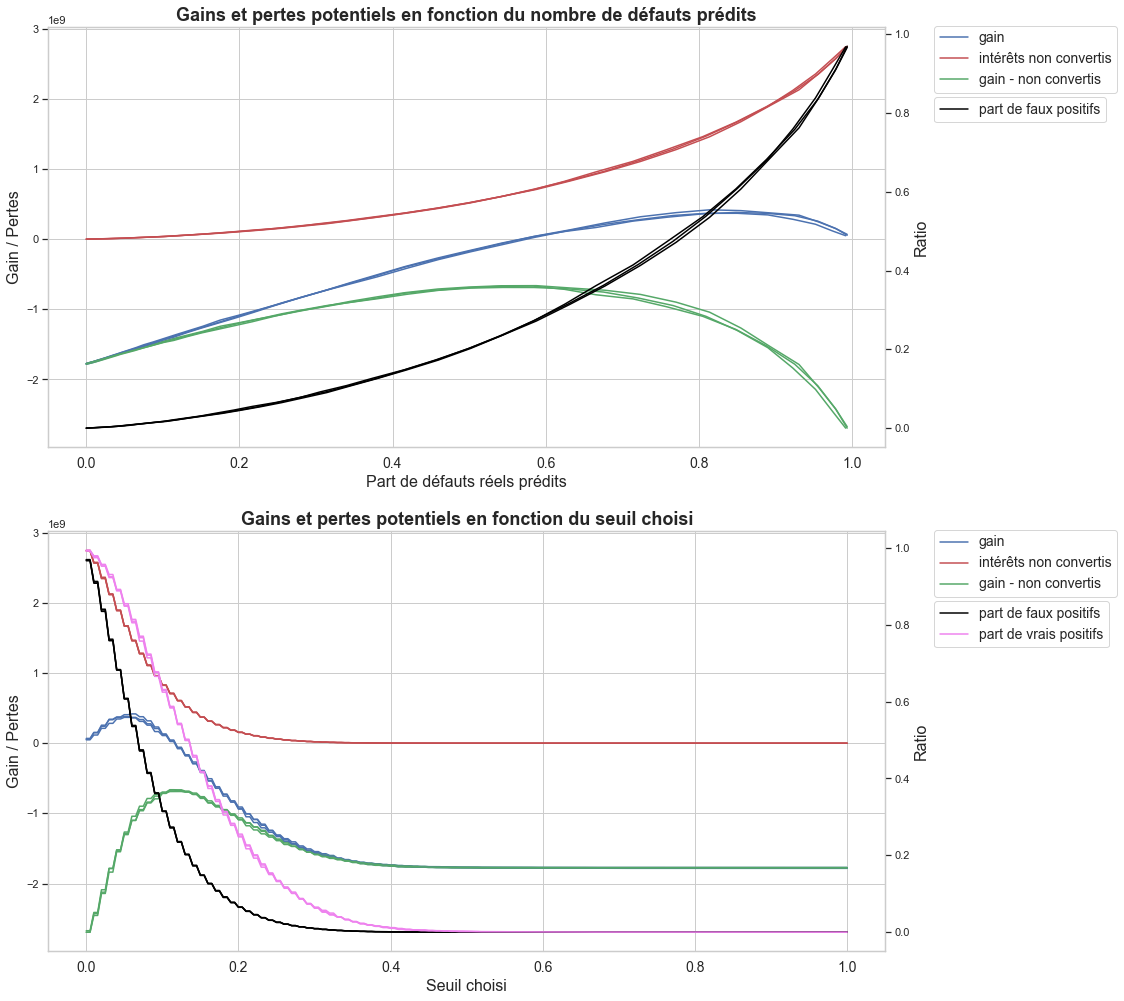

In [14]:
# Implementation of the pipeline consisting of imputer + classifier
# followed by training and prediction
imp = make_column_transformer((SimpleImputer(strategy='constant',
                                             fill_value=-1),
                               binary_var),
                              (SimpleImputer(strategy='median'),
                               quant_var)
                             )
model = make_pipeline(imp,
                      RandomForestClassifier(random_state=0))

results_RF, max_values_RF = money_viz(X=X_train, y=y_train, model=model,
                                      save_name='RF_V01')

In [15]:
max_values_RF

,threshold,gain,not_converted,tpr,fpr
max_gain,0.053333,388826304.0,1598921352.533334,0.837583,0.583723
max_gain-not_converted,0.113333,809207.466667,674077047.466667,0.571601,0.259857
zero_gain,0.115,35133115.733333,708672785.066667,0.585458,0.272387


On voit que les scores sont très stables avec une superposition presque parfaite des courbes des différents sous-échantillons (toutes de même couleurs).  
Concernant le choix de la valeur du recall à prendre en compte, à la vue des graphiques, 2 stratégies sont envisageables:
- La première consiste à déterminer le nombre de vrais positifs pour avoir le plus gros gain sans prendre en compte le nombre de clients perdus. Cela correspond au maximum de la courbe bleu. Elle s'appliquera à une stratégie de bénéfice basée uniquement sur les intérêts des prêts et c'est celle-ci que je considèrerais pour la suite du projet.
- La deuxième consiste à déterminer le recall en faisant un compromis entre le gain et le nombre de clients perdu. Cela correspond au maximum de la courbe verte. Elle s'appliquera à une stratégie de bénéfice globale basée non seulement sur les intérêts des prêts mais aussi sur la possibilité que les clients ouvrent d'autres comptes dans la banque. En termes de prêts, le gain sera proche de zéro mais le nombres de clients sera beaucoup plus importants avec moins de crédits refusés.  
  
Comme je considère la permière stratégie, alors je prend en compte le maximum de la courbe bleu qui correspond à un recall de 0.84 que j'arrondi à 0.85.

In [16]:
'''New definition of the score. It calculates the false-positive ratio for
a threshold which gives a 85% recall.
'''
def false_positive_ratio(y, y_prob):
    # Calculation  of the two classes population in the validation set
    count_real_pos = sum(y == 1)
    count_real_neg = sum(y == 0)

    # Array giving the predict_proba results for each sample of the two classes
    # The predict_proba results are sorted for the positive class
    proba_real_pos = np.sort(y_prob[y==1])
    proba_real_neg = y_prob[y==0]

    # Definition of the fixed recall
    ratio_85 = count_real_pos * 0.85
    # Calculation of the threshold to reach the fixed recall
    thr = proba_real_pos[:int(-ratio_85)-1:-1][-1]

    # Returns the false-positive ratio considering the calculated threshold
    return sum(proba_real_neg >= thr) / count_real_neg

# Construction of score from the function
custom_score = make_scorer(false_positive_ratio,
                           greater_is_better=False,
                           needs_proba=True)

La recherche des meilleurs paramètres d'imputation est répétée avec cette nouvelle fonction de coût.

In [13]:
score, trans = Impute_srategy(X=X_train, y=y_train,
                              binary_var=binary_var,
                              quant_var=quant_var,
                              binary_strategy=['most_frequent',
                                               'mean',
                                               'constant'],
                              quantitative_strategy=['mean',
                                                     'median',
                                                     'constant'],
                              binary_fill_value=[-1, 0],
                              quantitative_fill_value=[-999, -1, 0, 999]
                             )

  0%|                                                                                            | 0/4 [15:34<?, ?it/s]

  0%|                                                                                            | 0/4 [16:17<?, ?it/s]

  0%|                                                                                            | 0/4 [16:18<?, ?it/s]

  0%|                                                                                            | 0/4 [16:25<?, ?it/s]

  0%|                                                                                            | 0/4 [16:31<?, ?it/s]

  0%|                                                                                            | 0/4 [16:22<?, ?it/s]

  0%|                                                                                            | 0/4 [16:37<?, ?it/s]

  0%|                                                                                            | 0/4 [16:13<?, ?it/s]

100%|███████████████████████████

La plus petite proportion de prêt refusé à des personnes qui auraient remboursé est de: 0.62
Le meilleur transformer est: {'binary': 'mean', 'non-binary': 'constant', 'binary constant': -1, 'non-binary constant': -999}


La meilleure technique d'imputation des valeurs manquantes est donc d'imputer par:
- La moyenne pour les variables binaires.
- La valeur -999 pour les variables quantitatives.

# Algorithme de classification

## Choix de l'algorithme

Plusieurs algorithmes vont être testés. Tout d'abord, les valeurs manquantes seront imputées selon la stratégie définie ci-dessus. Dans le même temps, les données quantitatives seront normalisées grâce à un RobsutScaler. Puis, comme nous sommes dans le cas de classes déséquilibrées, je combinerais une augmentation de population pour la classe la moins représentée avec une réduction de la population de la classe la plus représentée grâce au package imblearn.  
Finalement, les différents algorithmes seront entrainés puis testés via une cross-validation.

In [17]:
'''Returns the train et test scores of a cross validation following a pipeline
with preprocessing (imputation and normalization), imbalanced classes
correction and supervised learning.

Parameters:
- model: scikit-learn object
The object to use to fit the data
- X: array-like of shape (n_samples, n_features)
The data to fit.
- y: array-like of shape (n_samples,)
The target variable to try to predict.
- n_splits: int
Number of folds of the cross-validation
- sampling_strategy_over: float
Sampling information to resample the data set. It corresponds to the desired
ratio of the number of samples in the minority class over the number of samples
in the majority class after resampling.
- sampling_strategy_under: float
Sampling information to sample the data set. It corresponds to the desired
ratio of the number of samples in the minority class over the number of samples
in the majority class after resampling.
- random_state: int
Control the randomization of the imblearn algorithms.

Return:
- mean_tr_score: float
Mean of the scores obtained in the train set in the different fold of the
cross-validation
- error_tr_score: array-like
Separate - and + error values compared to the mean of train scores.
First index contains the lower errors (mean - min), the second index contains
the upper errors (max - mean).
- mean_test_score: float
Mean of the scores obtained in the test set in the different fold of the
cross-validation
- error_test_score: array-like
Separate - and + error values compared to the mean of test scores.
First index contains the lower errors (mean - min), the second index contains
the upper errors (max - mean).
'''

def evaluation_algorithm(model, X, y, n_splits,
                         sampling_strategy_over, sampling_strategy_under,
                         random_state=None):

    # Definition of the cross-validation strategy
    cv = StratifiedKFold(n_splits=n_splits)

    # Quantitative features are imputed and then normalized
    quantitative_pipeline = make_pipeline(SimpleImputer(strategy='constant',
                                                        fill_value=-999),
                                          RobustScaler())
    binary_imputation = SimpleImputer(strategy='mean')

    # Implementation of preprocessing
    preprocess = make_column_transformer((binary_imputation, binary_var),
                                         (quantitative_pipeline, quant_var)
                                        )

    # Implementation of imbalanced classes correction
    over = SMOTE(sampling_strategy=sampling_strategy_over,
                 random_state=random_state)
    under = RandomUnderSampler(sampling_strategy=sampling_strategy_under,
                               random_state=random_state)

    # Implementation of the pipeline gathering preprocessing,
    # imbalanced correction and supervised learning algorithm.
    steps = [('pre', preprocess),
             ('over', over), ('under', under),
             ('model', model)]
    pipeline = Pipeline(steps=steps)

    scores = cross_validate(pipeline, X, y,
                            scoring=custom_score, cv=cv,
                            return_train_score=True)

    mean_tr_score = -np.mean(scores['train_score'])
    error_tr_score = np.array([np.max(scores['train_score'])+mean_tr_score,
                              -mean_tr_score-np.min(scores['train_score'])])
    mean_test_score = -np.mean(scores['test_score'])
    error_test_score = np.array([np.max(scores['test_score'])+mean_test_score,
                                 -mean_test_score-np.min(scores['test_score'])])

    return mean_tr_score, error_tr_score, mean_test_score, error_test_score

In [14]:
# Evaluation of different ML models
models = {'Logistic Regression':LogisticRegression(max_iter=500),
          'SGD Classifier':SGDClassifier(loss='modified_huber'),
          'KNeighbors Classifier':KNeighborsClassifier(),
          'Random Forest Classifier':RandomForestClassifier(),
          'Gradient Boosting Classifier':GradientBoostingClassifier(),
          'MLPClassifier':MLPClassifier()}

# Results stocked in a dataframe
results = pd.DataFrame(index = ['mean_tr', 'error_tr', 'mean_test',
                                'error_test', 'cal_time'])

for name, model in tqdm(models.items()):
    start_time = time.time()

    (mean_tr_score,
     error_tr_score,
     mean_test_score,
     error_test_score) = evaluation_algorithm(model=model,
                                              X=X_train,
                                              y=y_train,
                                              n_splits=3,
                                              sampling_strategy_over=0.2,
                                              sampling_strategy_under=0.5,
                                              random_state=1)

    cal_time = time.time() - start_time

    results[name] = [mean_tr_score, error_tr_score, mean_test_score,
                     error_test_score, cal_time]

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:20:13<00:00, 1402.18s/it]


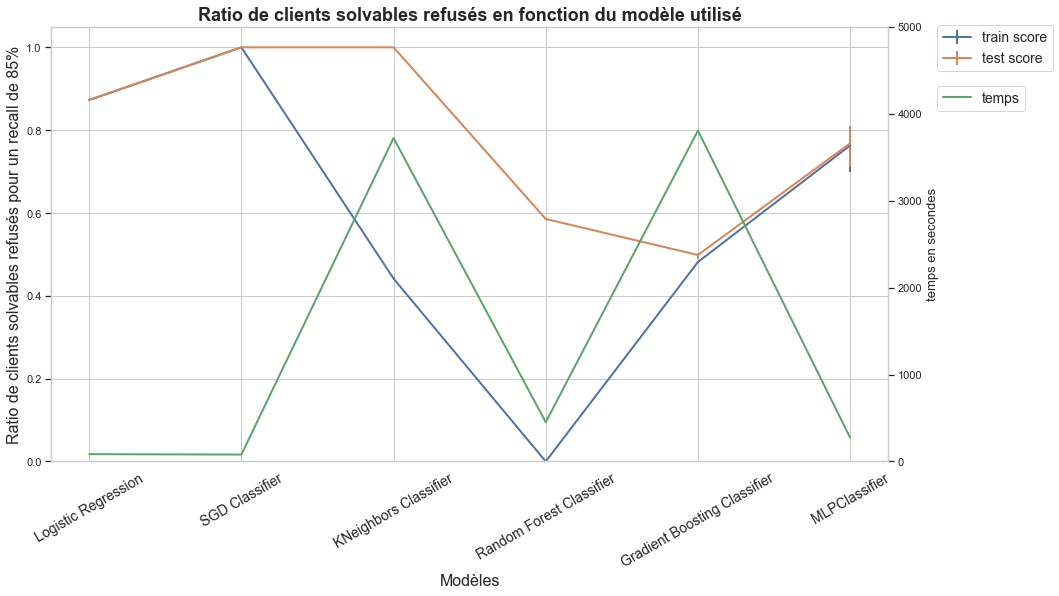

In [15]:
# Visualization of results
sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

ax1.errorbar(x=list(results.columns), y=list(results.loc['mean_tr',:]),
             yerr=np.array(list(results.loc['error_tr',:])).T,
             label='train score', lw=2)
ax1.errorbar(x=list(results.columns), y=list(results.loc['mean_test',:]),
             yerr=np.array(list(results.loc['error_test',:])).T,
             label='test score', lw=2)
ax1.set_ylim(0,1.05)
ax1.set_title(('Ratio de clients solvables refusés en fonction du modèle utilisé'),
              fontsize=18, fontweight=650)
ax1.set_xlabel('Modèles', fontsize=16)
ax1.tick_params(axis='x', rotation=30, labelsize=14)
ax1.set_ylabel('Ratio de clients solvables refusés pour un recall de 85%',
               fontsize=16)
ax1.legend(bbox_to_anchor=(1.05, 1.02), loc='upper left', fontsize=14)

ax2.plot(list(results.columns), list(results.loc['cal_time',:]),
             color='g', linewidth=2, label='temps')
ax2.set_ylim(0, 5000)
ax2.set_ylabel('temps en secondes', fontsize=13)
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.05, 0.88), loc='upper left', fontsize=14)

plt.savefig('./Output/score modèles.png',
            dpi=400,
            bbox_inches="tight"
           )

Le meilleur modèle est celui du Gradient Boosting mais son temps de calcul est très long par rapport aux autres modèles. Le modèle LightGBM, basé sur le gradient boosting mais avec, en général, des meilleures performances et des temps de calcul plus courts, va être testé dans les mêmes conditions.

In [16]:
start_time = time.time()

(mean_tr_score,
 error_tr_score,
 mean_test_score,
 error_test_score) = evaluation_algorithm(model=lgb.LGBMClassifier(),
                                          X=X_train,
                                          y=y_train,
                                          n_splits=3,
                                          sampling_strategy_over=0.2,
                                          sampling_strategy_under=0.5,
                                          random_state=1)

cal_time = time.time() - start_time

results['LightGBM'] = [mean_tr_score, error_tr_score, mean_test_score,
                       error_test_score, cal_time]

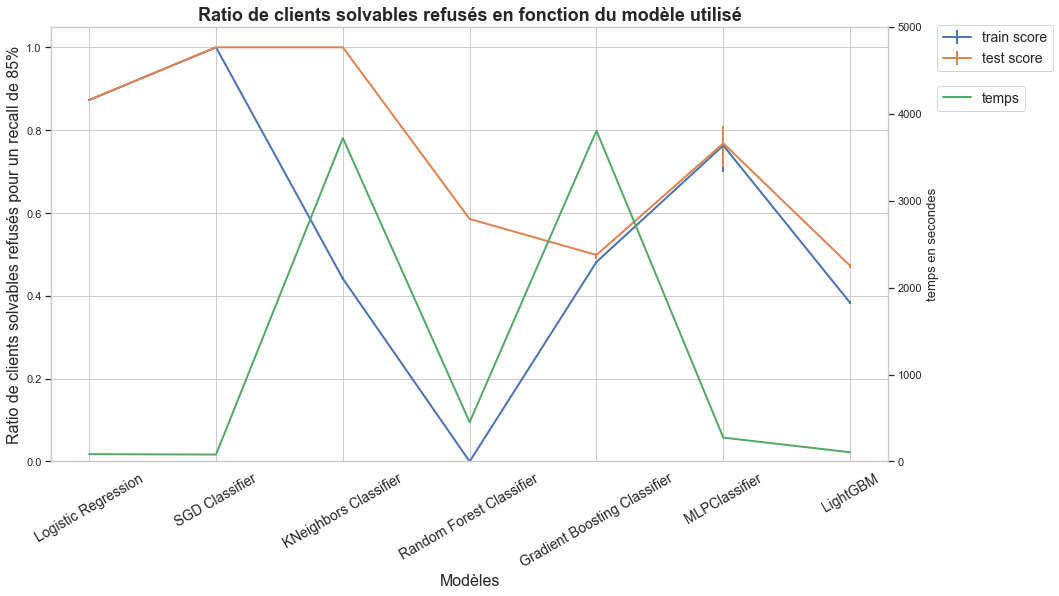

In [17]:
# Visualization of results
sns.set_theme(style='whitegrid')
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

ax1.errorbar(x=list(results.columns), y=list(results.loc['mean_tr',:]),
             yerr=np.array(list(results.loc['error_tr',:])).T,
             label='train score', lw=2)
ax1.errorbar(x=list(results.columns), y=list(results.loc['mean_test',:]),
             yerr=np.array(list(results.loc['error_test',:])).T,
             label='test score', lw=2)
ax1.set_ylim(0,1.05)
ax1.set_title(('Ratio de clients solvables refusés '
               'en fonction du modèle utilisé'),
              fontsize=18, fontweight=650)
ax1.set_xlabel('Modèles', fontsize=16)
ax1.tick_params(axis='x', rotation=30, labelsize=14)
ax1.set_ylabel('Ratio de clients solvables refusés pour un recall de 85%',
               fontsize=16)
ax1.legend(bbox_to_anchor=(1.05, 1.02), loc='upper left', fontsize=14)

ax2.errorbar(x=list(results.columns), y=list(results.loc['cal_time',:]),
             c='g', lw=2, label='temps')
ax2.set_ylim(0, 5000)
ax2.set_ylabel('temps en secondes', fontsize=13)
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.05, 0.88), loc='upper left', fontsize=14)

plt.savefig('./Output/score modèles with lgb.png',
            dpi=400,
            bbox_inches="tight"
           )

Le modèle LightGBM, en plus d'avoir un score équivalent au Gradient Boosting qui était le meilleur modèle, a un temps de calcul parmi les plus rapide de tous les modèles. Ainsi, ce modèle est conservé pour la suite des investigations.

## Optimisation de l'algorithme

### Hyperparamètres

Il faut maintenant définir les hyperparamètres de l'algorithme LightGBM pour obtenir les meilleurs résultats possibles. Une fonction qui va cibler aléatoirement, mais de plus en plus précisément, les valeurs optimales des hyperparamètres est mise en place.

In [18]:
'''Imputation of missing values according to their types.

Parameters:
- df: DataFrame
The dataframe with missing values

Return:
- result:dict
A dict with keys as:
   - imputer: Column transformer model from scikit learn
   Imputation model
   - binary: list
   List of binary features
   - non_binary: list
   List of quantitative features
   - new_features_order: list
   List of features in the order it will be returned after imputation
'''

def preprocessing(df):
    binary_var = [col for col in df.columns if len(df[col].unique())<4]
    quant_var = [col for col in df.columns if not col in binary_var]
    
    quantitative_imputation = SimpleImputer(strategy='constant',
                                            fill_value=-999)
    binary_imputation = SimpleImputer(strategy='mean')

    preprocess = make_column_transformer((binary_imputation, binary_var),
                                         (quantitative_imputation, quant_var)
                                        )

    new_features_order = binary_var.copy()
    new_features_order.extend(quant_var)
    
    result = {'imputer':preprocess,
              'binary':binary_var,
              'non_binary':quant_var,
              'features':new_features_order}
    
    return result

In [19]:
'''Optimisation of hyperparameters by a Random Search cross validation with
very brand range at first search. In an iterative way, the range of search is
then narrowed toward the best values.

Parameters:
- X: array-like of shape (n_samples, n_features)
The data to fit.
- y: array-like of shape (n_samples,)
The target variable to try to predict.
- param_factor: dictionnary
Dictionary with parameters names (str) as keys and a list as value.
First index of the list value represents the type of distribution to try.
Possible values are:
'uniform': A uniform distribution of float.
'uniform 0': A uniform distribution of float with 0 as a possible value.
'randint': A uniform distribution of int.
'list': A list of value to defined.
In case of 'uniform', 'uniform 0' or 'randint', the second index points out the
factor range of search compared to the best value.
Example: if the best value is 10, ['uniform', 1000] will perform a randomized
search from 0.01 to 10000 with uniform distribution.
In case of 'list', the second index is the list of values to test
- max_iter: int
Maximum number of parameter settings that are sampled.
- max_time: int
Maximum time (in minutes) the function could run
- n_splits: int
Number of folds of the cross-validation

Return:
- best_score: float
Lower false-positive ratio obtained for a recall of 85% as mean of the
cross-validation scores.
- best_param_v1: dictionary
Combination of hyperparameters which gives the best score
'''

def hyp_opt(X, y, param_factor, max_iter, max_time, n_splits=3):

    # Definition of the cross-validation strategy
    cv = StratifiedKFold(n_splits=n_splits)

    # Initialisation of time and the number of iterations
    start_time = time.time()
    n_test = 0

    # Calculation of score with standard parameters
    imputation = preprocessing(X)
    steps = [('pre', imputation['imputer']),
             ('over', SMOTE(sampling_strategy=0.2)),
             ('under', RandomUnderSampler(sampling_strategy=0.5)),
             ('model', lgb.LGBMClassifier())
            ]
    pipeline = Pipeline(steps=steps)
    scr = cross_val_score(pipeline, X, y,
                          scoring=custom_score, cv=cv)
    best_score = np.mean(scr)

    # Standard parameters
    best_param_v0 = {'model__learning_rate':0.1,
                     'model__n_estimators':100,
                     'model__class_weight':None,
                     'model__min_split_gain':0,
                     'model__min_child_samples':20,
                     'over_ratio': 0.2,
                     'under_ratio': 0.5
                    }
    best_param_v1 = best_param_v0.copy()

    # Initialisation of the number of change for each parameter
    par_mod = {'model__learning_rate':0,
               'model__n_estimators':0,
               'model__class_weight':0,
               'model__min_split_gain':0,
               'model__min_child_samples':0,
               'over_ratio':0,
               'under_ratio':0}

    param_grid = {}
    # Search for better parameter continue until max number of iteration
    while tqdm(n_test < max_iter):
        for param, factor in param_factor.items():
            # Randomly choice of SMOTE hyperparameter
            if param == 'over_ratio':
                min_val = best_param_v0[param] / factor[1]
                max_val = best_param_v0[param] * factor[1]
                over_ratio = ((max_val-min_val) * np.random.random_sample()
                               + min_val)
                if over_ratio < 0.2:
                    over_ratio = 0.2
                elif over_ratio > 0.7:
                    over_ratio = 0.7
            # Randomly choice of RandomUnderSampler hyperparameter
            # between over_ratio and 0.7
            # If this value is below over_ratio, model will have to add points
            elif param == 'under_ratio':
                min_val = over_ratio
                max_val = best_param_v0[param] * factor[1]
                under_ratio = ((max_val-min_val) * np.random.random_sample()
                                + min_val)
                if under_ratio > 0.7:
                    under_ratio = 0.7

            # Construction of param_distributions dictionnary
            else:
                if factor[0] == 'uniform':
                    param_grid[param] = uniform(loc=(best_param_v0[param]
                                                     / factor[1]),
                                                scale=(best_param_v0[param]
                                                       * factor[1]))
                elif factor[0] == 'randint':
                    param_grid[param] = randint(best_param_v0[param]/factor[1],
                                                best_param_v0[param]*factor[1])
                elif factor[0] == 'uniform 0':
                    param_grid[param] = uniform(loc=0,
                                                scale=(best_param_v0[param]
                                                       + factor[1]))
                elif factor[0] == 'list':
                    param_grid[param] = factor[1]

        # Construction of the pipeline
        imputation = preprocessing(X)
        steps = [('pre', imputation['imputer']),
                 ('over', SMOTE(sampling_strategy=over_ratio)),
                 ('under', RandomUnderSampler(sampling_strategy=under_ratio)),
                 ('model', lgb.LGBMClassifier())
                ]
        pipeline = Pipeline(steps=steps)

        # Implementation of the Randomized Search CV
        grid = RandomizedSearchCV(pipeline,
                                  param_distributions=param_grid,
                                  n_iter=5,
                                  scoring=custom_score,
                                  cv=cv)
        grid.fit(X, y)

        # Save of the best hyperparameters and relative score
        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_param_v1 = grid.best_params_
            best_param_v1['over_ratio'] = over_ratio
            best_param_v1['under_ratio'] = under_ratio

        # Stop the loop if max_time is reached
        if (time.time() - start_time) > (max_time * 60):
            break

        # Add 1 to the iteration count
        n_test += 1

        # Every 10 iterations, if best parameters is still the same
        # add 1 to the number of change
        if n_test%10 == 0:
            print(f'nombre de tests: {n_test}')
            print('temps moyen par test = '
                  f'{round(((time.time()-start_time)/n_test)/60,0)} minutes')
            print(f'Le meilleur score est: {round(best_score,3)}')
            print('le meilleur score est obtenu avec les hyperparamètes '
                  f'suivants: {best_param_v1}')

            for par, par_val in best_param_v1.items():
                if par_val == best_param_v0[par]:
                    par_mod[par] += 1
                else:
                    par_mod[par] = 0
                # If param stays unchanged four times in a row, it is fixed
                if par_mod[par] == 4:
                    if param_factor[par][0] == 'uniform':
                        param_factor[par][1] = 1
                    elif param_factor[par][0] == 'randint':
                        param_factor[par][1] = 1
                    elif param_factor[par][0] == 'uniform 0':
                        param_factor[par][1] = 0
                    elif param_factor[par][0] == 'list':
                        param_factor[par][1] = [par_val]

            best_param_v0 = best_param_v1.copy()

            # Every 10 iterations, reduce the search area by decreasing factors
            for param, factor in param_factor.items():
                if factor[0] != 'list':
                    param_factor[param][1] = factor[1]**0.8

    print('La plus petite proportion de prêts refusés à des personnes qui '
          f'auraient remboursé est de: {round(-best_score,2)}')
    print('le meilleur score est obtenu avec les hyperparamètes suivants: '
          f'{best_param_v1}')

    return best_score, best_param_v1

In [21]:
param_factor = {'model__learning_rate':['uniform', 1000],
                'model__n_estimators':['randint', 5],
                'model__class_weight':['list', ['balanced', None]],
                'model__min_split_gain':['uniform 0', 1],
                'model__min_child_samples':['randint', 5],
                'over_ratio':['uniform', 3],
                'under_ratio':['uniform', 3]}

bs, param = hyp_opt(X=X_train, y=y_train,
                    param_factor=param_factor,
                    max_iter=200, max_time=720)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


nombre de tests: 10
temps moyen par test = 7.0 minutes
Le meilleur score est: -0.475
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__class_weight': None, 'model__min_split_gain': 0, 'model__min_child_samples': 20, 'over_ratio': 0.2, 'under_ratio': 0.5}


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


nombre de tests: 20
temps moyen par test = 8.0 minutes
Le meilleur score est: -0.467
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__class_weight': None, 'model__learning_rate': 0.03214297248786433, 'model__min_child_samples': 34, 'model__min_split_gain': 0.28546668899961847, 'model__n_estimators': 341, 'over_ratio': 0.2740324044303199, 'under_ratio': 0.7}


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


nombre de tests: 30
temps moyen par test = 9.0 minutes
Le meilleur score est: -0.467
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__class_weight': None, 'model__learning_rate': 0.03214297248786433, 'model__min_child_samples': 34, 'model__min_split_gain': 0.28546668899961847, 'model__n_estimators': 341, 'over_ratio': 0.2740324044303199, 'under_ratio': 0.7}


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


nombre de tests: 40
temps moyen par test = 10.0 minutes
Le meilleur score est: -0.467
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__class_weight': None, 'model__learning_rate': 0.03214297248786433, 'model__min_child_samples': 34, 'model__min_split_gain': 0.28546668899961847, 'model__n_estimators': 341, 'over_ratio': 0.2740324044303199, 'under_ratio': 0.7}


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


nombre de tests: 50
temps moyen par test = 11.0 minutes
Le meilleur score est: -0.46
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__class_weight': None, 'model__learning_rate': 0.048096999991459194, 'model__min_child_samples': 61, 'model__min_split_gain': 0.9051154782133793, 'model__n_estimators': 460, 'over_ratio': 0.2164872667372205, 'under_ratio': 0.30550750135582305}


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


nombre de tests: 60
temps moyen par test = 11.0 minutes
Le meilleur score est: -0.46
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__class_weight': None, 'model__learning_rate': 0.048096999991459194, 'model__min_child_samples': 61, 'model__min_split_gain': 0.9051154782133793, 'model__n_estimators': 460, 'over_ratio': 0.2164872667372205, 'under_ratio': 0.30550750135582305}


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


La plus petite proportion de prêts refusés à des personnes qui auraient remboursé est de: 0.46
le meilleur score est obtenu avec les hyperparamètes suivants: {'model__class_weight': None, 'model__learning_rate': 0.048096999991459194, 'model__min_child_samples': 61, 'model__min_split_gain': 0.9051154782133793, 'model__n_estimators': 460, 'over_ratio': 0.2164872667372205, 'under_ratio': 0.30550750135582305}


Finalement, les hyperparamètres pour la suite des investigations seront:
- Learning rate = 0.048
- Minimum number of data needed in a child = 61
- Minimum loss reduction required to make a further partition on a leaf node of the tree = 0.905
- Number of estimators = 460
- Ratio of the number of samples in the minority class to over-sample over the number of samples in the majority class after resampling = 0.216
- Ratio of the number of samples in the minority class over the number of samples to under-sample in the majority class after resampling = 0.3055

### Nombre de features

Une fois les hyperparamètres optimisés, il faut optimiser le nombre de features en éliminant toutes les features inutiles (voire avec un impact négatif). Pour cela, je vais définir une fonction qui, de manière itérative, éliminera une fraction des features les moins importantes et recalculera le score de la prédiction. Tant que celui-ci est inférieur ou équivalent, on répète l'opération. Par la suite, afin de ne garder que les features les plus importantes, à partir des features déterminées par la première fonction, le processus repartira de zéro en ajoutant une à une les features donnant le meilleur résultat jusqu'à obtenir un résultat similaire au meilleur résultat obtenu.

In [20]:
'''Construction of the model with best hyperparameters'''

def final_model(X, random_state=None):
    imputation = preprocessing(X)
    steps = [('pre', imputation['imputer']),
             ('over', SMOTE(sampling_strategy=0.216,
                            random_state=random_state)),
             ('under', RandomUnderSampler(sampling_strategy=0.3055,
                                          random_state=random_state)),
             ('model', lgb.LGBMClassifier(learning_rate=0.048,
                                          min_child_samples=61,
                                          min_split_gain=0.905,
                                          n_estimators=460,
                                          random_state=random_state))
            ]
    pipeline = Pipeline(steps=steps)
    
    result = {'model':pipeline,
              'binary':imputation['binary'],
              'non_binary':imputation['non_binary'],
              'features':imputation['features']}
    
    return result

In [21]:
'''Optimisation of the features used in the classification model.
Less important features are recursively eliminated until performance decreases.

Parameters:
- X: array-like of shape (n_samples, n_features)
The data to fit.
- y: array-like of shape (n_samples,)
The target variable to try to predict.
- margin_error: float
margin of error of the final score. In practice, the function stops removing
features when score (less_is_better) is above the best_score + margin_error
- ratio_elim: float
fraction of features to remove at each iteration.
- n_splits: int
Number of folds of the cross-validation
- random_state: int, RandomState instance or None, default=None
When shuffle is True, random_state affects the ordering of the indices, which
controls the randomness of each fold. Otherwise, this parameter has no effect.
Pass an int for reproducible output across multiple function calls.

Return:
- results: dictionary
A dict with keys as:
   - score = evolution of score during iteration
   - feat_elim = features removed
   - feat_kept = features kept
These three lists are repeated for each fold of cross-validation
'''

def nbfeat_opt(X, y,
               margin_error=0.01, ratio_elim=0.03,
               n_splits=3, random_state=None):

    scores_ls_ = []
    feat_elim_ls = []
    # Prediction using all the features
    feat_imp_df = pd.DataFrame()
    score_ls = []
    # Definition of the cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits)
    for nb, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        Xtr = X.iloc[train_idx,:].copy()
        Xval = X.iloc[test_idx,:].copy()
        ytr = y.iloc[train_idx].copy()
        yval = y.iloc[test_idx].copy()


        model_res = final_model(Xtr, random_state=random_state)
        model = model_res['model']
        features = model_res['features']
        model.fit(Xtr, ytr)
        ypred = model.predict_proba(Xval)[:,1]
        score = false_positive_ratio(yval, ypred)
        score_ls.append(score)
        feat_imp_df[f'fold{nb}'] = model['model'].feature_importances_
    mean_score = np.mean(score_ls)
    scores_ls_.append(mean_score)
    feat_imp_mean = list(np.mean(feat_imp_df, axis=1))
    print(f'score initial: {round(mean_score, 3)}')

    # New prediction after elimination of less important features
    # Stop iteration if performance decreases
    while mean_score < np.min(scores_ls_) + margin_error:
        n_elim = int(ratio_elim * len(features))
        feat_to_drop = [features[idx] for idx in
                        np.argsort(feat_imp_mean)[0:n_elim]]
        feat_elim_ls.extend(feat_to_drop)
        
        feat_imp_df = pd.DataFrame()
        score_ls = []
        # Definition of the cross-validation strategy
        skf = StratifiedKFold(n_splits=n_splits)
        for nb, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            Xtr = X.iloc[train_idx,:].copy()
            Xval = X.iloc[test_idx,:].copy()
            ytr = y.iloc[train_idx].copy()
            yval = y.iloc[test_idx].copy()
        
            Xtr.drop(feat_elim_ls, axis=1, inplace=True)
            model_res = final_model(Xtr, random_state=random_state)
            model = model_res['model']
            features = model_res['features']
            model.fit(Xtr, ytr)
            ypred = model.predict_proba(Xval)[:,1]
            score = false_positive_ratio(yval, ypred)
            score_ls.append(score)
            feat_imp_df[f'fold{nb}'] = model['model'].feature_importances_
        mean_score = np.mean(score_ls)
        scores_ls_.append(mean_score)
        feat_imp_mean = list(np.mean(feat_imp_df, axis=1))
        print(f'features restantes = {len(feat_imp_mean)}')
        print(f'nouveau score: {round(mean_score, 3)}')

    feat_elim_ls = feat_elim_ls[:-n_elim]
    feat_kept = [feat for feat in X_train.columns if not feat in feat_elim_ls]

    return feat_kept, feat_elim_ls, scores_ls_

In [22]:
best_feat, feat_rmv, scores_list = nbfeat_opt(X_train, y_train,
                                   margin_error=0.01, ratio_elim=0.03,
                                   n_splits=3, random_state=8)

score initial: 0.465
features restantes = 772
nouveau score: 0.465
features restantes = 749
nouveau score: 0.464
features restantes = 727
nouveau score: 0.462
features restantes = 706
nouveau score: 0.461
features restantes = 685
nouveau score: 0.461
features restantes = 665
nouveau score: 0.461
features restantes = 646
nouveau score: 0.463
features restantes = 627
nouveau score: 0.46
features restantes = 609
nouveau score: 0.462
features restantes = 591
nouveau score: 0.462
features restantes = 574
nouveau score: 0.462
features restantes = 557
nouveau score: 0.459
features restantes = 541
nouveau score: 0.461
features restantes = 525
nouveau score: 0.461
features restantes = 510
nouveau score: 0.462
features restantes = 495
nouveau score: 0.461
features restantes = 481
nouveau score: 0.464
features restantes = 467
nouveau score: 0.46
features restantes = 453
nouveau score: 0.463
features restantes = 440
nouveau score: 0.462
features restantes = 427
nouveau score: 0.463
features restan

In [23]:
'''Optimisation of the features used in the classification model.
Features which minimises the score (less_is_better) are recursively added until
reaching performance obtained with all features.

Parameters:
- X: array-like of shape (n_samples, n_features)
The data to fit.
- y: array-like of shape (n_samples,)
The target variable to try to predict.
- base_score: float
Target score to reach.
- features_ls: list
List of features to test
- margin_error: float
margin of error of the final score. In practice, the function stops adding
features when score (less_is_better) is below the best_score + margin_error
- n_splits: int
Number of folds of the cross-validation
- random_state: int, RandomState instance or None, default=None
When shuffle is True, random_state affects the ordering of the indices, which
controls the randomness of each fold. Otherwise, this parameter has no effect.
Pass an int for reproducible output across multiple function calls.

Return:
- col_kept: list
List of minimum features to reach the best performance
- best_score: float
Score obtained with the above list of features
'''

def nbfeat_opt_forward(X, y, base_score, features_ls,
                       margin_error=0.01,
                       n_splits=3, random_state=None):

    best_score = base_score

    score_max = 1
    col_kept = []
    # Adding features until reaching best_score
    while score_max > best_score + margin_error:
        scores_col = []
        # List of features to test
        columns_ls = [col for col in features_ls if not col in col_kept]
        # Each feature is tested
        for col in tqdm(columns_ls):
            score = []
            # Definition of the cross-validation strategy
            skf = StratifiedKFold(n_splits=n_splits)
            for nb, (train_idx, test_idx) in enumerate(skf.split(X, y)):
                Xtr = X.iloc[train_idx,:].copy()
                Xval = X.iloc[test_idx,:].copy()
                ytr = y.iloc[train_idx].copy()
                yval = y.iloc[test_idx].copy()

                # Add the feature to the ones already chosen
                columns = col_kept.copy()
                columns.append(col)
                # Prediction using these features
                newXtr = Xtr[columns]
                newXval = Xval[columns]
                model_res = final_model(newXtr, random_state=random_state)
                model = model_res['model']
                model.fit(newXtr, ytr)
                ypred = model.predict_proba(newXval)[:,1]
                score.append(false_positive_ratio(yval, ypred))
            # Score as mean of the scores obtained in the cross validation
            # Score for each feature is stacked in a list
            scores_col.append(np.mean(score))
        # Best score and its corresponding feature are isolated
        score_max = np.min(scores_col)
        idx_max = np.argmin(scores_col)
        col_kept.append(columns_ls[idx_max])
        print(f'score = {score_max}')
        print(f'column kept = {columns_ls[idx_max]}')

    # Once the base_score reached,
    # try to improve the score by adding more features
    best_score = 1
    while score_max < best_score - (margin_error/2):
        best_score = score_max
        scores_col = []
        columns_ls = [col for col in features_ls if not col in col_kept]
        for col in tqdm(columns_ls):
            skf = StratifiedKFold(n_splits=n_splits)
            score = []
            for nb, (train_idx, test_idx) in enumerate(skf.split(X, y)):
                Xtr = X.iloc[train_idx,:].copy()
                Xval = X.iloc[test_idx,:].copy()
                ytr = y.iloc[train_idx].copy()
                yval = y.iloc[test_idx].copy()

                columns = col_kept.copy()
                columns.append(col)
                newXtr = Xtr[columns]
                newXval = Xval[columns]
                model_res = final_model(newXtr, random_state=random_state)
                model = model_res['model']
                model.fit(newXtr, ytr)
                ypred = model.predict_proba(newXval)[:,1]
                score.append(false_positive_ratio(yval, ypred))
            scores_col.append(np.mean(score))
        score_max = np.min(scores_col)
        idx_max = np.argmin(scores_col)
        col_kept.append(columns_ls[idx_max])
        print(f'score = {score_max}')
        print(f'column kept = {columns_ls[idx_max]}')

    if score_max < best_score:
        best_score = score_max
    else:
        col_kept = col_kept[:-1]
        
    return col_kept, best_score

In [24]:
col_kept, best_score = nbfeat_opt_forward(X=X_train, y=y_train,
                                          base_score=np.min(scores_list),
                                          features_ls=best_feat,
                                          margin_error=0.01,
                                          n_splits=3,
                                          random_state=8)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [08:01<00:00,  5.41s/it]


score = 0.6790032315484481
column kept = PAYMENT_RATE


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [08:28<00:00,  5.78s/it]


score = 0.6079056933448667
column kept = EXT_SOURCE_2


100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [09:52<00:00,  6.81s/it]


score = 0.5805109633888379
column kept = EXT_SOURCE_3


100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [10:31<00:00,  7.35s/it]


score = 0.5630248639640935
column kept = AMT_ANNUITY


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [11:31<00:00,  8.13s/it]


score = 0.5523238093709965
column kept = EXT_SOURCE_1


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [12:22<00:00,  8.84s/it]


score = 0.5388705316783852
column kept = REGION_POPULATION_RELATIVE


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [13:59<00:00, 10.11s/it]


score = 0.5315442771984246
column kept = CC_CNT_DRAWINGS_ATM_CURRENT_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [14:29<00:00, 10.60s/it]


score = 0.525159014616143
column kept = APPROVED_AMT_CREDIT_MAX


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [15:22<00:00, 11.39s/it]


score = 0.5209528910981479
column kept = CODE_GENDER


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [14:32<00:00, 10.91s/it]


score = 0.5141572647949287
column kept = APPROVED_AMT_DOWN_PAYMENT_MAX


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [15:24<00:00, 11.70s/it]


score = 0.5110725189709883
column kept = DAYS_BIRTH


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [15:28<00:00, 11.91s/it]


score = 0.5062331637974301
column kept = FLAG_OWN_CAR


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [15:38<00:00, 12.19s/it]


score = 0.5016237301220279
column kept = AMT_GOODS_PRICE


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [15:31<00:00, 12.25s/it]


score = 0.4966570196494137
column kept = INSTAL_PAYMENT_DIFF_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [15:27<00:00, 12.36s/it]


score = 0.491895480168709
column kept = BURO_DAYS_CREDIT_ENDDATE_MAX


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [32:01<00:00, 25.96s/it]


score = 0.4885454309372443
column kept = NAME_EDUCATION_TYPE_Higher education


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [31:42<00:00, 26.07s/it]


score = 0.4866988409146901
column kept = INSTAL_AMT_PAYMENT_SUM


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [30:31<00:00, 25.43s/it]


score = 0.4811024343907702
column kept = PREV_CNT_PAYMENT_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [30:25<00:00, 25.72s/it]


score = 0.48102814641824493
column kept = CLOSED_DAYS_CREDIT_MAX


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [29:48<00:00, 25.55s/it]


score = 0.4793230698420912
column kept = POS_MONTHS_BALANCE_MAX


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [30:00<00:00, 26.09s/it]


score = 0.4788950047859631
column kept = PREV_NAME_YIELD_GROUP_high_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [30:03<00:00, 26.52s/it]


score = 0.47916385712533877
column kept = INSTAL_DPD_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [29:04<00:00, 26.04s/it]


score = 0.47712976733696544
column kept = DAYS_EMPLOYED_PERC


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [28:37<00:00, 26.03s/it]


score = 0.47339766929017885
column kept = PREV_DAYS_DECISION_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [28:16<00:00, 26.09s/it]


score = 0.47380447645813367
column kept = REGION_RATING_CLIENT_W_CITY


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [29:21<00:00, 27.52s/it]


score = 0.47165365541549226
column kept = ANNUITY_INCOME_PERC


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [29:37<00:00, 28.21s/it]


score = 0.4703872210496485
column kept = INSTAL_DBD_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [28:51<00:00, 27.93s/it]


score = 0.4719083571160272
column kept = DEF_30_CNT_SOCIAL_CIRCLE


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [28:14<00:00, 27.77s/it]


score = 0.4697009198150037
column kept = ACTIVE_AMT_CREDIT_SUM_SUM


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [28:27<00:00, 28.46s/it]


score = 0.4693542353016087
column kept = ACTIVE_DAYS_CREDIT_MEAN


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [28:10<00:00, 28.66s/it]


score = 0.4677128229159899
column kept = NAME_FAMILY_STATUS_Married


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [28:40<00:00, 29.66s/it]


score = 0.46540280965481146
column kept = BURO_AMT_CREDIT_SUM_MAX


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [29:39<00:00, 31.21s/it]

score = 0.4663261026200212
column kept = DAYS_LAST_PHONE_CHANGE


In [25]:
X_train_fin = X_train[col_kept]
X_test_fin = X_test[col_kept]
print(f'Nombre de features retenues = {len(col_kept)}')

Nombre de features retenues = 32


Finalement, sur les presque 800 features de départ, 32 features sont conservées pour la prédiction.

## Stabilité de l'algorithme

Maintenant que l'algorithme a été optimisé, je vais vérifier sa capacité à être stable au niveau des prévisions. Pour cela, je vais faire des séparations aléatoires du jeu de données et voir les résultats obtenus.

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:42:25<00:00, 122.91s/it]


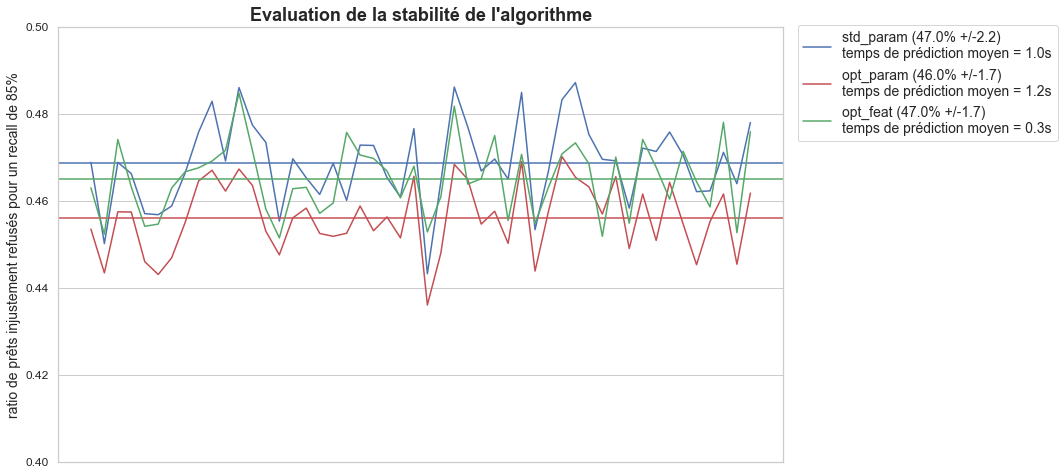

In [26]:
'''Visualisation of model stability. In addition, differences between standard
model and optimized one (hyperparameters and number of features) are also
assessed.
'''

# Definition of models
imputation = preprocessing(X_train)
steps = [('pre', imputation['imputer']),
         ('over', SMOTE(sampling_strategy=0.2)),
         ('under', RandomUnderSampler(sampling_strategy=0.5)),
         ('model', lgb.LGBMClassifier())
        ]
model_std = Pipeline(steps=steps)
feat_std = imputation['features']
opt_param_res = final_model(X_train)
opt_feat_res = final_model(X_train_fin)

models_list = [model_std, opt_param_res['model'], opt_feat_res['model']]
name_sel = ['std_param', 'opt_param', 'opt_feat']
features = [feat_std, opt_param_res['features'], opt_feat_res['features']]
results = {name:[] for name in name_sel}
predict_time = {name:[] for name in name_sel}

# Calculation of prediction score for randomly chosen train and validation sets
for _ in tqdm(range(50)):
    Xtr, Xval, ytr, yval = train_test_split(X_train, y_train, test_size=0.20)
    for model, feat, name in zip(models_list, features, name_sel): 
        model.fit(Xtr[feat], ytr)
        start_time = time.time()
        ypred = model.predict_proba(Xval[feat])[:,1]
        predict_time[name].append(time.time()-start_time)
        results[name].append(false_positive_ratio(yval, ypred))

# Visualization of results
color = ['b', 'r', 'g']
sns.set_theme(style='whitegrid')
plt.figure(figsize=(13,8))
for name, col in zip(name_sel, color):
    rslt = results[name]
    mean_score = np.mean(rslt)
    mean_predict_time = np.mean(predict_time[name])
    error_margin = (np.max(rslt) - np.min(rslt)) / 2
    plt.plot(range(50), results[name], c=col)
    plt.axhline(y=mean_score, c=col,
                label=(f'{name} ({round(mean_score*100,0)}% '
                       f'+/-{round(error_margin*100,1)})\n'
                       'temps de prédiction moyen = '
                       f'{round(mean_predict_time,1)}s'))
plt.title('Evaluation de la stabilité de l\'algorithme',
          fontsize=18, fontweight=650)
plt.xticks([])
plt.grid(False, axis='x')
plt.ylabel('ratio de prêts injustement refusés pour un recall de 85%',
           fontsize=14)
plt.yticks(fontsize=12)
plt.ylim((0.4,0.5))
plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=14)
plt.savefig('./Output/stabilité.png',
            dpi=400,
            bbox_inches="tight"
           )

Pour terminer mon analyse du modèle de classification je vais tracer la courbe d'apprentissage.

[learning_curve] Training set sizes: [ 20500  30211  39921  49632  59343  69053  78764  88475  98186 107896
 117607 127318 137028 146739 156450 166161 175871 185582 195293 205004]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ................., score=(train=-0.080, test=-0.521) total time=   1.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[CV] START .....................................................................
[CV] END ................., score=(train=-0.111, test=-0.508) total time=   1.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[CV] START .....................................................................
[CV] END ................., score=(train=-0.135, test=-0.494) total time=   1.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[CV] START ..

[CV] END ................., score=(train=-0.287, test=-0.481) total time=   5.3s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  2.7min remaining:    0.0s
[CV] START .....................................................................
[CV] END ................., score=(train=-0.294, test=-0.485) total time=   5.9s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.8min remaining:    0.0s
[CV] START .....................................................................
[CV] END ................., score=(train=-0.302, test=-0.485) total time=   6.9s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.9min remaining:    0.0s
[CV] START .....................................................................
[CV] END ................., score=(train=-0.313, test=-0.480) total time=   6.5s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  3.0min remaining:    0.0s
[CV] START .....................................................................
[CV] END ................., scor

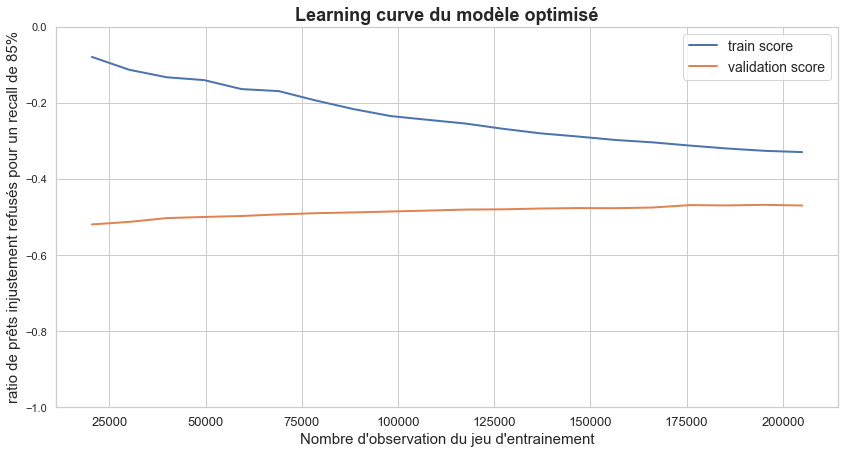

In [27]:
model_res = final_model(X_train_fin, random_state=8)
cv = StratifiedKFold(n_splits=3)
    
N, tr_scr, val_scr = learning_curve(model_res['model'],
                                    X_train_fin, y_train,
                                    train_sizes=np.linspace(0.1, 1, 20),
                                    cv=cv,
                                    scoring=custom_score,
                                    verbose=100)

sns.set_theme(style='whitegrid')
plt.figure(figsize=(14,7))
plt.plot(N, tr_scr.mean(axis=1), label='train score', lw=2)
plt.plot(N, val_scr.mean(axis=1), label='validation score', lw=2)
plt.title('Learning curve du modèle optimisé', fontsize=18, fontweight=650)
plt.xlabel('Nombre d\'observation du jeu d\'entrainement', fontsize=15)
plt.ylabel('ratio de prêts injustement refusés pour un recall de 85%',
           fontsize=15)
plt.xticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylim((-1,0))
plt.legend(fontsize=14)

plt.savefig('./Output/learning curve.png',
            dpi=400,
            bbox_inches="tight"
           )

Le modèle utilisé s'avère stable avec un overfitting léger. On va donc pouvoir l'utiliser dans un modèle de scoring

# Stratégie de scoring

Afin de définir la stratégie de scoring, je vais tracer de nouveau les courbes de gain avec le nouveau modèle optimisé.

0it [00:00, ?it/s]C:\Users\Pierre\AppData\Local\Temp/ipykernel_9708/1780203564.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[thr] = [thr, gain, not_converted, tpr, fpr]
1it [00:14, 14.92s/it]C:\Users\Pierre\AppData\Local\Temp/ipykernel_9708/1780203564.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[thr] = [thr, gain, not_converted, tpr, fpr]
2it [00:29, 14.52s/it]C:\Users\Pierre\AppData\Local\Temp/ipykernel_9708/1780203564.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

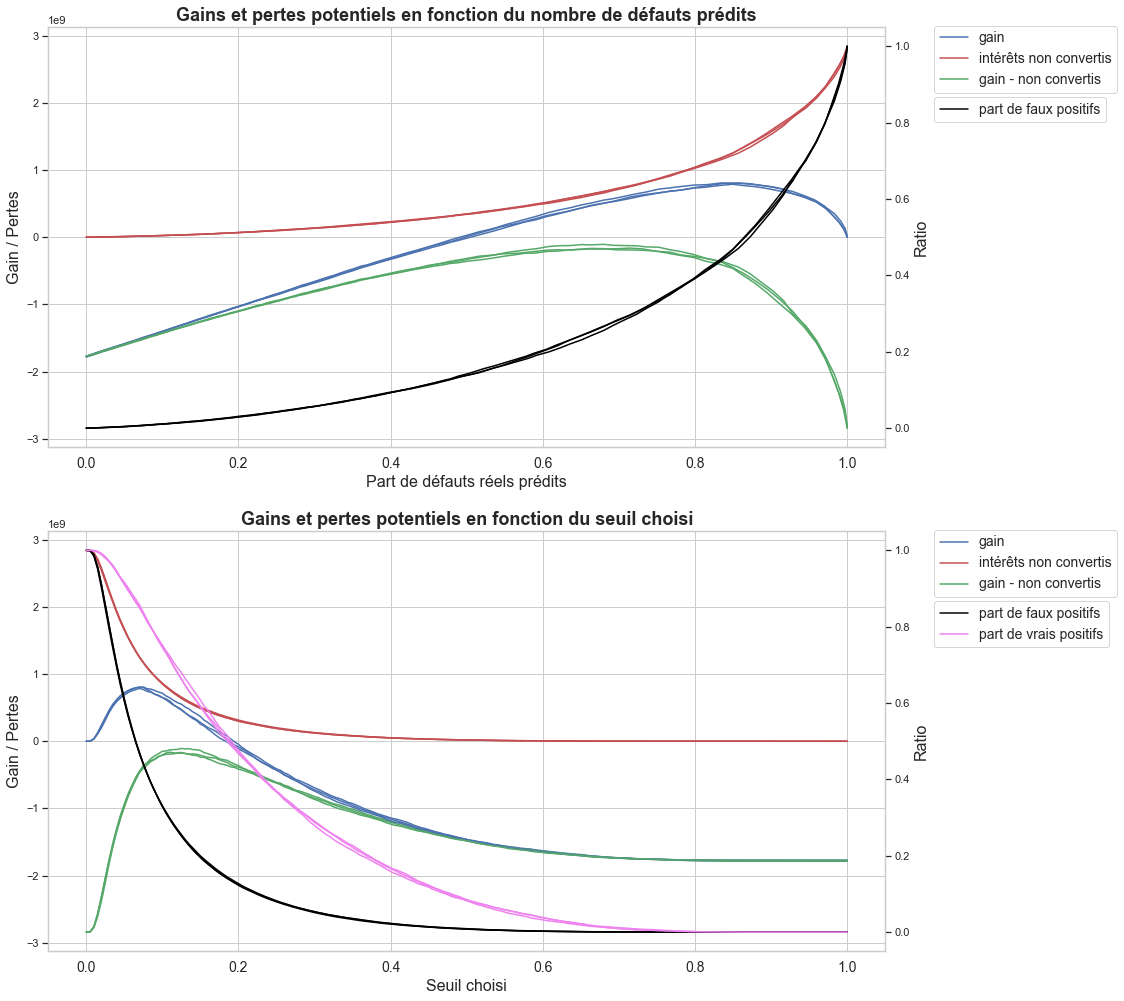

In [28]:
model_res = final_model(X_train_fin, random_state=8)
results_LGBM, max_values_LGBM = money_viz(X=X_train_fin, y=y_train,
                                          model=model_res['model'],
                                          save_name='LGBM_Vfin')

In [29]:
max_values_LGBM

,threshold,gain,not_converted,tpr,fpr
max_gain,0.071667,800938884.266667,1226028885.333333,0.846969,0.459495
max_gain-not_converted,0.12,540709128.533333,685635737.6,0.685881,0.267651
zero_gain,0.185,28041642.666667,352611814.4,0.506586,0.142871


Grâce à ce graphique, il va être possible de définir une échelle de score allant de 1 à 4:
- Score 1: Le meilleur score. Crédit accepté dans tous les cas. Va correspondre à une valeur du predict_proba comprise entre 0 et 0.072 qui correspond au threshold du gain maximum
- Score 2: Avis plutôt favorable pour une acceptation du crédit. A voir en fonction du crédit et du profil du client. Va correspondre à une valeur du predict_proba qui ira jusqu'à 0.12 qui correspond au threshold du gain potentiel (gain - non converti) maximum.
- Score 3: Avis plutôt défavorable. A voir en fonction du crédit et du profil du client. Va correspondre à une valeur du predict_proba qui ira jusqu'à 0.185 qui correspond au threshold d'un gain nul.
- Score 4: Le plus mauvais score. Refus du crédit dans tous les cas. Pour une valeur de predict_proba au-delà du threshold précédent et jusqu'à 1.

# Exportation des données

Afin de pouvoir construire cette fonction à l'intérieur d'une API Rest dans l'optique d'un déploiement, je vais sauver le model et les données tests pour une utilisation extérieure. J'en profite pour sauver aussi des informations intéressantes pour les différentes demandes de crédit.

In [30]:
model_res = final_model(X_train_fin)
model_res['model'].fit(X_train_fin, y_train)

joblib.dump(model_res, './Output/model_dict.joblib')
X_test_fin.to_csv('./Output/X_test.csv')
X_train_fin.to_csv('./Output/X_train.csv')
y_train.to_csv('./Output/y_train.csv')

input_df = pd.read_csv('./Input/application_test.csv', index_col='SK_ID_CURR')
feat_interest = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL',
                 'FLAG_OWN_REALTY', 'CODE_GENDER', 'NAME_FAMILY_STATUS']
info_df = input_df[feat_interest].copy()
info_df['BURO_AMT_CREDIT_SUM_DEBT_SUM'] = X_test['BURO_AMT_CREDIT_SUM_DEBT_SUM']
info_df.to_csv('./Output/info.csv')

In [36]:
model = model_res['model']
bin_feat = model_res['binary']
quant_feat = model_res['non_binary']
features = model_res['features']

# Scoring jeu de test

Afin de visualiser la répartition des différents scores obtenu dans l'échantillon de jeu de test, on fonction de scoring va être définie à partir des recommandations données ci-dessus puis appliquée aux probabilités calculées de l'échantillon test.

In [18]:
'''Get score from the probability given by the model prediction'''
def get_score(proba):
    if proba <= 0.072:
        score = 1
    elif proba > 0.072 and proba <= 0.12:
        score = 2
    elif proba > 0.12 and proba <= 0.185:
        score = 3
    else:
        score = 4
    return score

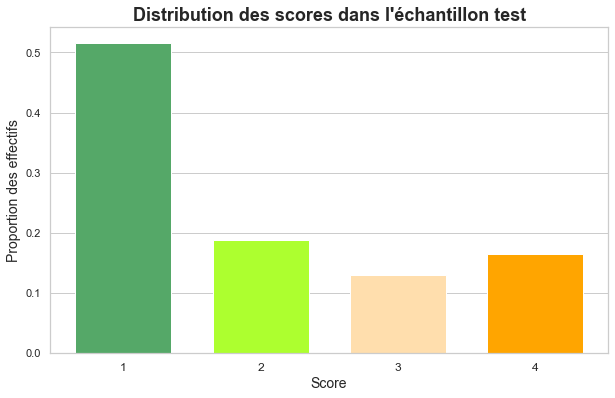

In [19]:
proba_Xtest = model.predict_proba(X_test_fin)[:,1]
score_Xtest = np.array([get_score(prob) for prob in proba_Xtest])
score, counts = np.unique(score_Xtest, return_counts=True)

sns.set_theme(style='whitegrid')
plt.figure(figsize=(10,6))
plt.bar(score, counts/len(score_Xtest),
        width=0.7,
        color=['g', 'greenyellow', 'navajowhite', 'orange']
       )
plt.title('Distribution des scores dans l\'échantillon test',
          fontsize=18, fontweight=650)
plt.xticks([1,2,3,4], fontsize=12)
plt.xlabel('Score', fontsize=14)
plt.grid(False, axis='x')
plt.ylabel('Proportion des effectifs', fontsize=14)
plt.savefig('./Output/distribution score X_test.png',
            dpi=400,
            bbox_inches="tight"
           )

On voit sur le graphique que prêt de la moitié des crédits peuvent être accordés.

# Importance des features dans le modèle

Dans un but de compréhension de l'apport de chaque features dans le modèle, leur importance va être évalué grâce au package "shap". L'impact globale de chaque feature va d'abord être évalué.

In [32]:
'''Imputation of missing values in train and test datas'''
imp = model[0]
Xtr_trans = pd.DataFrame(imp.transform(X_train_fin),
                         index=X_train_fin.index,
                         columns=features)
Xtest_trans = pd.DataFrame(imp.transform(X_test_fin),
                           index=X_test_fin.index,
                           columns=features)

In [33]:
import shap
shap.initjs()

In [34]:
explainer = shap.TreeExplainer(model[3])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


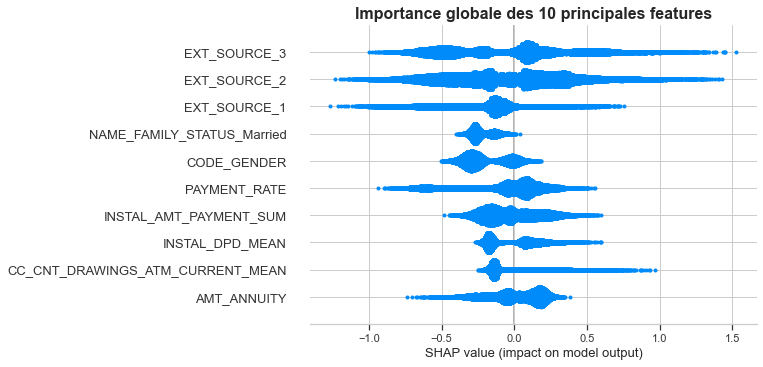

In [35]:
# Visualization of global importance of the first 10 features
shap.summary_plot(explainer.shap_values(Xtest_trans)[1],
                  feature_names=features, max_display=10, show=False)
plt.title('Importance globale des 10 principales features',
          fontsize=16, fontweight=650)
plt.savefig('./Output/shap_values.png',
            dpi=400,
            bbox_inches="tight"
           )

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


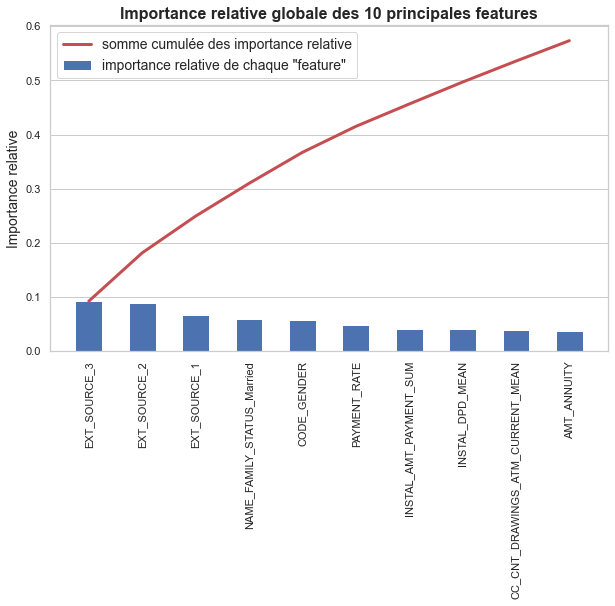

In [40]:
# Vizualisation of absolute values of global importance
sv_global = explainer.shap_values(Xtest_trans)[1]
features_sv = np.sum(np.abs(sv_global), axis=0)
features_sv_idx = np.argsort(features_sv)
top10_idx = features_sv_idx[:-11:-1]
imp_feat = [features[idx] for idx in top10_idx]
imp_ratio = [features_sv[idx]/np.sum(features_sv) for idx in top10_idx]

sns.set_theme(style='whitegrid')
plt.figure(figsize=(10,6))
plt.bar(imp_feat, imp_ratio, color='b', width=0.5,
        label='importance relative de chaque "feature"')
plt.plot(imp_feat, np.cumsum(imp_ratio), color='r', lw=3,
         label='somme cumulée des importance relative')
plt.title('Importance relative globale des 10 principales features',
          fontsize=16, fontweight=650)
plt.xticks(rotation=90)
plt.ylabel('Importance relative', fontsize=14)
plt.legend(fontsize=14)
plt.grid(False, axis='x')
plt.savefig('./Output/shap_values_relative.png',
            dpi=400,
            bbox_inches="tight"
           )

Avec les 10 features les plus importantes, il est possible d'expliquer presque 60% des résultats du modèle.